# Fuzzy Run Challenge

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import find_peaks

## Load data

In [2]:
dfMatt = pd.read_csv("../data/matt.csv")

## Adjust data: start time at zero, change acceleration units

This is just for normalisation purposes

In [4]:
dfMatt.time = dfMatt.time - dfMatt.time.min()
dfMatt.loc[:,["aX", "aY", "aZ"]] = dfMatt.loc[:,["aX", "aY", "aZ"]] * 9.8

In [5]:
dfMatt

,time,aX,aY,aZ,gX,gY,gZ
0,0,7.493555,0.421094,6.378613,0.183105,-3.479004,-2.563477
1,10,7.723242,0.406738,6.507813,0.061035,-3.601074,-2.441406
2,20,7.560547,0.277539,6.316406,0.122070,-3.540039,-2.563477
3,30,7.469629,0.416309,6.340332,0.427246,-3.356934,-2.624512
4,40,7.436133,0.397168,6.388184,0.488281,-3.295898,-2.685547
...,...,...,...,...,...,...,...
14400,144000,5.670410,-0.248828,7.967285,0.183105,-3.479004,-2.685547
14401,144010,5.675195,-0.244043,7.991211,0.244141,-3.417969,-2.624512
14402,144020,5.608203,-0.267969,7.986426,0.183105,-3.295898,-2.685547
14403,144030,5.589063,-0.229688,7.976855,0.244141,-3.356934,-2.746582


## Plot acceleration time series

Each component

<AxesSubplot:>

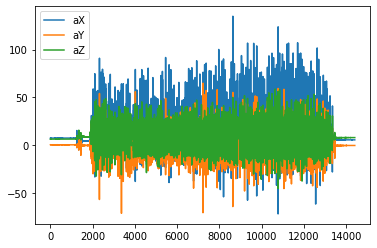

In [6]:
dfMatt.loc[:, ["aX", "aY", "aZ"]].plot()

## Plot velocity using integration - note how it grows, and grows...

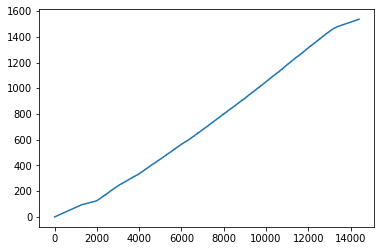

In [7]:
v = sp.integrate.cumtrapz(dfMatt.aX, x=dfMatt.time / 1000)
plt.plot(v)

# PCA approach

So we'll need to massage this data a bit more. First, PCA

Principle component analysis: the first axis of PCA is the 'major axis', in our case that should be acceleration projected into the direction of motion.

We'll add PCA values to the same data frame that we're already using

<AxesSubplot:>

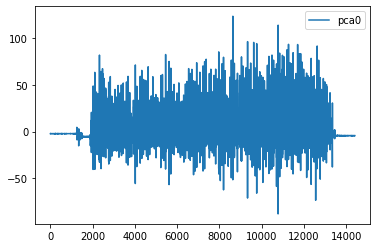

In [11]:
dfMatt.loc[:,["pca0", "pca1", "pca2"]] = PCA().fit_transform(dfMatt.loc[:,["aX", "aY", "aZ"]].values)
dfMatt.loc[:, ["pca0"]].plot()

In [12]:
dfMatt

,time,aX,aY,aZ,gX,gY,gZ,pca0,pca1,pca2
0,0,7.493555,0.421094,6.378613,0.183105,-3.479004,-2.563477,-2.188041,-4.346282,-2.349743
1,10,7.723242,0.406738,6.507813,0.061035,-3.601074,-2.441406,-1.988285,-4.182270,-2.296333
2,20,7.560547,0.277539,6.316406,0.122070,-3.540039,-2.563477,-2.128624,-4.409017,-2.203115
3,30,7.469629,0.416309,6.340332,0.427246,-3.356934,-2.624512,-2.205191,-4.388301,-2.350777
4,40,7.436133,0.397168,6.388184,0.488281,-3.295898,-2.685547,-2.248680,-4.348645,-2.333052
...,...,...,...,...,...,...,...,...,...,...
14400,144000,5.670410,-0.248828,7.967285,0.183105,-3.479004,-2.685547,-4.330654,-3.151818,-1.821546
14401,144010,5.675195,-0.244043,7.991211,0.244141,-3.417969,-2.624512,-4.329656,-3.127097,-1.824023
14402,144020,5.608203,-0.267969,7.986426,0.183105,-3.295898,-2.685547,-4.397098,-3.145156,-1.809574
14403,144030,5.589063,-0.229688,7.976855,0.244141,-3.356934,-2.746582,-4.409547,-3.154323,-1.850615


# Now let's try to count steps

Step counting comes down to counting peaks in the timeseries. Note that this isn't affected strongly by the noise, unlike when we attempt to calculate velocity. So if we can *count* steps, then we can identify where they appear in the timeseries, which could be helpful.

In [13]:
def get_peaks(data):
    pos_kwargs={
        "distance": 20,
        "height": (35, None)
    }
    peaks, _ = find_peaks(data, **pos_kwargs)
    return np.hstack([[0],peaks,[len(data)-1]])

def get_step_ranges(data):
    peaks = get_peaks(data)
    midpoints = (peaks[1:] + peaks[:-1]) / 2
    return np.vstack([midpoints[:-1], midpoints[1:]]).T.round()

steps = get_step_ranges(dfMatt.pca0)
steps.shape

(140, 2)

*n.b. you should get 140 steps out of this!*

# Looking at a single step

The step is two values indicating the start and end index into the timeseries.

In [14]:
step = steps[100]
print(step)

[10306. 10378.]


## Velocity-time graph over this step

Integrate between the start and end of this step

9.543656358780677

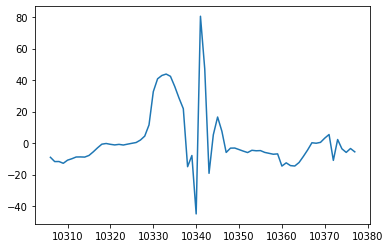

In [15]:
a, b = step.astype(int)
ms_to_kmh = 3.6 # we'll convert from metres per second to kilometres per hour

velocity = sp.integrate.cumtrapz(dfMatt.pca0.iloc[a:b], x=dfMatt.time.iloc[a:b] / 1000) * ms_to_kmh

# Let's find the maximum
display(pd.Series(velocity).abs().max())

# Plot the series
dfMatt.pca0.iloc[a:b].plot()
plt.show()